In [3]:
from google.colab import drive
drive.mount('/content/drive')

from tensorflow.keras import models, layers, datasets
import tensorflow as tf

tf.device('/device:GPU:0')

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images = 1./255 * train_images
test_images = 1./255 * test_images

Mounted at /content/drive
170500096/170498071 [==============================] - 6s 0us/step


In [2]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

model.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

def load_model(name):
    try:
        model.load_weights('/content/drive/MyDrive/training_checkpoints/'+name)
        return True
    except:
        return False

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

import numpy as np
from scipy.special import softmax
import itertools, tqdm

# load_model('checkpoint_correct')
options = np.asarray([i for i in range(10)])
def compute_per_class_losses():
    all_predictions = model.predict(test_images)
    all_predictions = np.clip(softmax(all_predictions, axis=1), 
                              np.finfo(np.float32).eps, 
                              1. - np.finfo(np.float32).eps)
    indicators = test_labels == options
    return -1/10000 * np.sum(indicators * np.log2(all_predictions) + (1 - indicators) * np.log2(1 - all_predictions), axis=0)

def compute_all_class_losses():
    results = {a: [] for a in itertools.combinations(class_names, 2)}
    for (fst, snd), idx in tqdm.tqdm(list(itertools.product(itertools.combinations(class_names, 2), range(10)))):
        first_class = class_names.index(fst)
        second_class = class_names.index(snd)
        if load_model(f'checkpoint_{fst}_{snd}_{idx}'):
            results[(fst, snd)].append(compute_per_class_losses())
    for (fst, snd), v in list(results.items()):
        #print(len(v))
        results[(fst, snd)] = (v, np.mean(np.asarray(v), axis=0), np.var(np.asarray(v), axis=0))
        #results[(snd, fst)] = results[(fst, snd)]
    return results

mean_model_losses = compute_all_class_losses()

In [ ]:
def compute_per_model_probabilities():
    all_predictions = model.predict(test_images)
    all_predictions = np.clip(softmax(all_predictions, axis=1), 
                              np.finfo(np.float32).eps, 
                              1. - np.finfo(np.float32).eps)
    true_label_to_average_prediction = {}
    test_labs = test_labels.flatten()
    for i in range(10):
        cur_preds = all_predictions[test_labs == i]
        true_label_to_average_prediction[i] = np.mean(cur_preds, axis=0)
    return true_label_to_average_prediction

def compute_all_model_probs():
    results = {a: [] for a in itertools.combinations(class_names, 2)}
    for (fst, snd), idx in tqdm.tqdm(list(itertools.product(itertools.combinations(class_names, 2), range(10)))):
        first_class = class_names.index(fst)
        second_class = class_names.index(snd)
        if load_model(f'checkpoint_{fst}_{snd}_{idx}'):
            results[(fst, snd)].append(compute_per_model_probabilities())
    return results

all_model_probabilities = compute_all_model_probs()

In [ ]:
import pickle
with open('/content/drive/MyDrive/training_checkpoints/pickled_mean_model_losses', 'wb') as f:
    pickle.dump(mean_model_losses, f)
with open('/content/drive/MyDrive/training_checkpoints/pickled_all_model_probs', 'wb') as f:
    pickle.dump(all_model_probabilities, f)

In [4]:
import pickle
with open('/content/drive/MyDrive/training_checkpoints/pickled_mean_model_losses', 'rb') as f:
    mean_model_losses = pickle.load(f)
with open('/content/drive/MyDrive/training_checkpoints/pickled_all_model_probs', 'rb') as f:
    all_model_probabilities = pickle.load(f)

In [ ]:
corr_results = []
for idx in range(20):
    if load_model(f'checkpoint_correct_{idx}'):
        corr_results.append(compute_per_class_losses())
corr_results = (corr_results, np.mean(np.asarray(corr_results), axis=1), np.var(np.asarray(corr_results), axis=1))

In [ ]:
def welchs_t_test_confused_yes_v_no(target_class, confused_class):
    confused_yes = []
    confused_no = []
    for conf_pair, losses in mean_model_losses.items():
        samples, losses, variances = losses
        if class_names[target_class] in conf_pair:
            continue
        if class_names[confused_class] in conf_pair:
            for s in samples:
                confused_yes.append(s[target_class])
        else:
            for s in samples:
                confused_no.append(s[target_class])
    confused_yes = np.array(confused_yes)
    confused_no = np.array(confused_no)
    c_yes_mean, c_yes_stdv = np.mean(confused_yes), np.std(confused_yes)
    c_no_mean, c_no_stdv = np.mean(confused_no), np.std(confused_no)
    N_yes, N_no = confused_yes.shape[0], confused_no.shape[0]
    t = (c_yes_mean - c_no_mean) / np.sqrt(c_yes_stdv**2/N_yes + c_no_stdv**2/N_no)
    nu = (c_yes_stdv**2/N_yes + c_no_stdv**2/N_no)**2 / (c_yes_stdv**4/(N_yes**2 * (N_yes-1))+ c_no_stdv**4/(N_no**2 * (N_no-1)))
    #print(nu)
    return t

# print(welchs_t_test_confused_yes_v_no(1,9))
# print(welchs_t_test_confused_yes_v_no(1,2))
# print(welchs_t_test_confused_yes_v_no(0,1))
all_t_statistic = [[welchs_t_test_confused_yes_v_no(i, j) if i != j else 0 for i in range(10)] for j in range(10)]

tstats_dict = {(i,j): all_t_statistic[i][j] for i in range(10) for j in range(10)}
# FROM NU APPROXIMATION AROUND 100-150
p_05 = 1.98
p_02 = 2.358
p_01 = 2.617
p_002 = 3.16
p_001 = 3.373
# print(dict(sorted(tstats_dict.items(), key=lambda item: item[1])))
# IF IT IS POSITIVE: then, the loss went UP on the target class when we confused the second
# THIS MEANS THAT THE MODEL'S UNDERSTANDING OF THE TARGET IS SUPPLEMENTED BY THE UNDERSTANDING OF THE SECOND
# NEGATIVE means that the presence of training on that second actually causes it to screw up the target!!
# conclusions: the model really does not like learning deer versus truck! 
# most negative correlations are messing up something human-made with something natural or vice versa!
# birds and dogs are somewhat friendly!
# cars and trucks are similar :)
# cars and.... frogs? are similar? could it be the eyes versus the headlights?
for k, v in tstats_dict.items():
    if abs(v) > p_001:
        print(f'p_001 significant t-value for target {class_names[k[0]]} against {class_names[k[1]]}: {v}')
    elif abs(v) > p_002:
        print(f'p_002 significant t-value for target {class_names[k[0]]} against {class_names[k[1]]}: {v}')
    elif abs(v) > p_01:
        print(f'p_01 significant t-value for target {class_names[k[0]]} against {class_names[k[1]]}: {v}')
    elif abs(v) > p_02:
        print(f'p_02 significant t-value for target {class_names[k[0]]} against {class_names[k[1]]}: {v}')
    elif abs(v) > p_05:
        print(f'p_05 significant t-value for target {class_names[k[0]]} against {class_names[k[1]]}: {v}')

p_01 significant t-value for target airplane against dog: -2.7849672212629204
p_05 significant t-value for target automobile against frog: 2.1162936297135233
p_02 significant t-value for target automobile against truck: 2.5416603249155068
p_05 significant t-value for target bird against dog: 2.129818130027395
p_05 significant t-value for target bird against ship: -1.9985830997721628
p_05 significant t-value for target deer against airplane: -2.2166739911532645
p_01 significant t-value for target deer against truck: -2.912974281882193
p_05 significant t-value for target frog against airplane: -2.2339242667723544
p_05 significant t-value for target truck against deer: -2.1423349624416574


In [5]:
import numpy as np

averaged_all_model_probabilities = {}
for k, v in all_model_probabilities.items():
    mean_result = {}
    for i in range(10):
        whoISshe = np.array([aa[i] for aa in v])
        #print(whoISshe.shape)
        mean_result[i] = np.mean(whoISshe, axis=0)
    averaged_all_model_probabilities[k] = mean_result

print(averaged_all_model_probabilities.keys())
print(averaged_all_model_probabilities[('automobile', 'truck')])

dict_keys([('airplane', 'automobile'), ('airplane', 'bird'), ('airplane', 'cat'), ('airplane', 'deer'), ('airplane', 'dog'), ('airplane', 'frog'), ('airplane', 'horse'), ('airplane', 'ship'), ('airplane', 'truck'), ('automobile', 'bird'), ('automobile', 'cat'), ('automobile', 'deer'), ('automobile', 'dog'), ('automobile', 'frog'), ('automobile', 'horse'), ('automobile', 'ship'), ('automobile', 'truck'), ('bird', 'cat'), ('bird', 'deer'), ('bird', 'dog'), ('bird', 'frog'), ('bird', 'horse'), ('bird', 'ship'), ('bird', 'truck'), ('cat', 'deer'), ('cat', 'dog'), ('cat', 'frog'), ('cat', 'horse'), ('cat', 'ship'), ('cat', 'truck'), ('deer', 'dog'), ('deer', 'frog'), ('deer', 'horse'), ('deer', 'ship'), ('deer', 'truck'), ('dog', 'frog'), ('dog', 'horse'), ('dog', 'ship'), ('dog', 'truck'), ('frog', 'horse'), ('frog', 'ship'), ('frog', 'truck'), ('horse', 'ship'), ('horse', 'truck'), ('ship', 'truck')])
{0: array([0.6852283 , 0.03788231, 0.06378357, 0.02582576, 0.02642436,
       0.01281666

In [25]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

def compute_kl_divergence_all_confused_vs_only_target(target_class, confused_class):
    
    #M_with_frog[car_ind][car_ind] * log_2(M_with_frog[car_ind][car_ind]/M_mean[car_ind][car_ind]) + sum(1 - M_with_frog[not_car_ind][car_ind]) * (1- log_2(M_with_frog[not_car_ind][car_ind])/(1-M_mean[not_car_ind][car_ind])),not_car_inds)

    assert(target_class != confused_class)
    confused_yes = []
    confused_overall = []
    for conf_pair, probabilities in averaged_all_model_probabilities.items():
        probabilities = np.array([probabilities[i] for i in range(10)])
        if class_names[target_class] in conf_pair:
            continue
        if class_names[confused_class] in conf_pair:
            confused_yes.append(probabilities)
        confused_overall.append(probabilities)
    confused_yes = np.mean(np.array(confused_yes), axis=0)
    confused_overall = np.mean(np.array(confused_overall), axis=0)
    # x = 0
    #return -1/10000 * np.sum(indicators * np.log2(all_predictions) + (1 - indicators) * np.log2(1 - all_predictions), axis=0)
    kldiv = 0.
    for i in range(10):
        if i == target_class:
            with_ = confused_yes[i][target_class]
            overall_ = confused_overall[i][target_class]
        else:
            with_ = 1 - confused_yes[i][target_class]
            overall_ = 1 - confused_overall[i][target_class]
        kldiv += with_ * np.log2(with_/overall_)
    return kldiv
    #kldiv = confused_yes[target_class, target_class] * np.log2()
    
    # modeling these both as gaussians!!
    #kl = np.log2(ov_var/yes_var) + ((yes_var**2)+(yes_mean - ov_mean)**2)/(2*ov_var**2) - 1/2

all_kl_divs = [[compute_kl_divergence_all_confused_vs_only_target(i, j) if i != j else 0. for i in range(10)] for j in range(10)]

(10, 10)


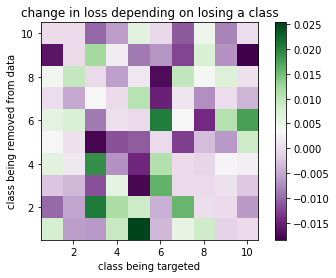

In [28]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors
#class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
#               'dog', 'frog', 'horse', 'ship', 'truck']

data = np.array(all_kl_divs)
print(data.shape)
rows, cols = data.shape

fig = plt.imshow(data, interpolation='nearest', 
                 extent=[0.5, 0.5+cols, 0.5, 0.5+rows],
                 cmap='PRGn')

plt.colorbar()
fig.axes.set_xlabel('class being targeted')
fig.axes.set_ylabel('class being removed from data')

title = fig.axes.set_title('change in loss depending on losing a class')

# higher values means the loss was higher when this was included!!
# lower values means the loss was lower when this was included!!